# Visualization of Targeted Chemical Cross-Linking Data

A supplement Notebook for producing plots related to **Identification of Protective Antibodies using _in silico_ Protein Docking coupled with Targeted Chemical Cross-Linking Mass Spectrometry** (unpublished manuscript).

---

## TOC

- [Notebook instructions](#notebook-instructions)
- [Packages](#packages)
  - [Descriptions](#descriptions)
  - [Imports](#imports)
- [Variables](#variables)
- [Functions](#functions)
- [Analysis](#analysis)
  - [Cross-linking summary](#cross-linking-summary)
  - [Structural analysis](#structural-analysis)

---

## Notebook instructions

There are two dropdown menus in this Notebook that allow for user input. [The first one](#(-!-)-Subset-selection:-receiver) sets the antigen of interest (for a cursory look), [while the second](#(-!-)-Subset-selection:-ligand) sets the antibody to perform further structural analysis on. If `run all` was executed initially, change the menu option and select `run below` from the subsequent code box.

## Packages

Below are short descriptions of the packages required to run this Notebook, presented in `import` order. All required packages are easily installed through the use of `conda` and the included environment.yml (for further detail check the project [GitHub-repo](https://github.com/COMPUTE-Jupyter-course/project-for-compute-jupyter-2022-jstrobaek)).

### Descriptions

#### pickle

- Used to load a python variable, stored in `.pkl` format.

#### sqlite3

- **Imported to alias `sql`.** For SQLite database querying of stored upstream data.

#### itertools

- Used for infinite integer generator.

#### math

- Used to round up to closest multiple of ten (using `ceil`).

#### pathlib

- Utilized for assignment of I/O files and related path handling.

#### typing

- Used for soft type-setting of functions.

#### matplotlib

- **Imported to alias `plt`.** For creating a superimposed subplot, format axis decimal points, and setting the default format of the plots produced.

#### nglview

- **Imported to alias `nv`.** Used to visualize molecular (here protein) structures in Jupyter Notebooks.

#### ipywidgets

- **Imported to alias `widgets`.** Included for creation of dropdown menus.

#### pandas

- **Imported to alias `pd`.** Utilized for data wrangling.

#### seaborn

- **Imported to alias `sns`.** Used to create plots.

#### Bio

- Short for `Biopython`, which is used for I/O operations with biological data (e.g. in `.pdb` or `.fasta` format) and generating parse-able python objects of imported data.

#### Ipython

- Required for generating markdown rich-text from within a code block (with `Ipython.display.Markdown`).

#### Cellscape

- Used to generate stylized molecular 

### Imports

In [1]:
# Package imports:
import pickle
import sqlite3 as sql
from itertools import count
from math import ceil
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
import ipywidgets as widgets
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from Bio.PDB import PDBParser, PPBuilder, Selection, Structure
from IPython.display import HTML, Markdown
from ipywidgets import fixed, interact, Layout
from matplotlib.ticker import StrMethodFormatter
from matplotlib_inline import backend_inline
from pandas import DataFrame

import cellscape

### Gobal package options

In [2]:
# Set plot related global options:
backend_inline.set_matplotlib_formats('svg')  # Set plot format.
sns.set_theme(style="whitegrid")  # Set plot theme.

# Create output directory:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

# Add option to toggle code cells:
toggle_code = HTML('''<script>
                   code_show=false; 
                   function code_toggle() {
                       if (code_show){
                           $('div.input').hide();
                       } else {
                           $('div.input').show();
                       }
                       code_show = !code_show
                   }$( document ).ready(code_toggle);
                   </script>
                   <form action="javascript:code_toggle()">
                       <input type="submit" value="Toggle code">
                   </form>''')

## Variables

To not crowd the notebook with uninteresting code, the below variable(s) are stored in `.pkl` files and imported at runtime. Pickle files are currently found in the [GitHub repo](https://github.com/COMPUTE-Jupyter-course/project-for-compute-jupyter-2022-jstrobaek), but will be moved to a corresponding Zenodo repo at a later date.

In [3]:
# Variable imports:
with open('vars/aa_3to1.pkl', 'rb') as f:

    aa_3to1 = pickle.load(f)

## Functions

Imported from a utility script (`./utils/functions.py`) to declutter the Notebook.

In [4]:
# Import utility functions:
from utils.functions import *

## Toggle code cells

Use the below button to toggle code cells within this Notebook.

In [5]:
toggle_code

## Analysis




<img src="images/gr1_lrg.jpg" align="left" width="350px" style="display=block">

The antigen of interest (the *Streptococcus pyogenes* M1 membrane bound protein; left) has no complete crystal structure available through the Protein Data Bank ([PDB](https://www.rcsb.org/)) and is hard to model and dock *in silico* due to its size and flexibility. For this reason it has been split into its constituent repeat domains (A/B/C/D) during data processing. For the sake of simplicity, only two (the B and C repeat regions) are represented in the test set. In the below drop-down meny (*Subset selection: reciever*) one of these regions can be chosen for subsequent visualization.

<span style="line-height:515px;"><br></span> 
<small>Image source: <a href="https://doi.org/10.1016/S1473-3099(03)00576-0">doi.org/10.1016/S1473-3099(03)00576-0</a><small/>

### **( ! )** Subset selection: receiver

Select antigen (receiver) of interest in the below dropdown. To rerun the analysis with a different antigen select a new item in the dropdown, and rerun the cells below the input box. The selection names corresponds to the following M1 repeat domain:

|Variable name|M1 domain|
|-:|:-
|m1-b_rep|B repeat variable domain|
|m1-c_rep|C repeat conserved domain|

In [6]:
# Display dropdown to enable data subset selection.
receivers = [p.name for p in Path('data').resolve().glob('*')]

receivers.sort()

receiver_subset = widgets.Dropdown(options=receivers,
                                   value=receivers[0],
                                   description='Receiver:', disabled=False)

display(receiver_subset)

Dropdown(description='Receiver:', options=('M1-b_rep', 'M1-c_rep'), value='M1-b_rep')

### Cross-linking summary

Load and summarize upstream data for the selected receiver (antigen).

In [7]:
# Get ligand names from dir names.
receiver = receiver_subset.value

base_dir = Path(f'data/{receiver}').resolve()

if not base_dir.is_dir():

    text = f'The requested directory ("{base_dir}") does not exist.'

    raise FileNotFoundError(text)

ligands = tuple((path.name for path in base_dir.iterdir()))

# Read upstream data (of all ligands) from SQLite database to a dataframe.
db_file = 'ms2_results.sql'  # Hardcoded database filename.

df = pd.concat({receiver:
                pd.concat({ligand:
                           sql_to_df(db_file=base_dir / ligand / db_file)
                           for ligand in ligands}, axis=0)}, axis=0)

# Create a new dataframe with counts (based on type) for each ligand.
theoretical_xls = {}

supported_xls = {}

counts = {'ligand': [], 'observed_xls': [], 'xls_below_cut-off': []}

for ligand in ligands:

    ms2_xls = df.loc[(receiver,), 'XL'][ligand].tolist()

    top_xls = !cat {base_dir / ligand / 'top_xls.txt'}

    theoretical_xls[ligand] = ms2_xls

    supported_xls[ligand] = top_xls

    counts['ligand'].append(ligand)

    counts['observed_xls'].append(len(ms2_xls))

    counts['xls_below_cut-off'].append(len(top_xls))

counts_df = pd.DataFrame.from_dict(counts)

counts_df.columns.name = receiver

counts_df.sort_values(by='observed_xls', ascending=False, inplace=True)

<br />

Display the DataFrame holding upstream cross-linking data:

In [8]:
df

XL  \
M1-b_rep igs   0          -.ATALEKELEEK(6)--QSNNKYMASSYLTLTAR(5).-   
               1                 -.ATALEKELEEK(6)--PGETVKISCK(6).-   
               2                      -.ELEEKK(5)--PGETVKISCK(6).-   
               3          -.KEALELAIDQASR(1)--SPLTFGAGTKLELK(10).-   
               4  -.KEALELAIDQASR(1)--VDGTPVTQGMETTQPSKQSNNK(17).-   
...                                                            ...   
         top02 3                       -.ELEEKK(5)--GKATLTVNK(2).-   
               4  -.KEALELAIDQASR(1)--VDGTPVTQGMETTQPSKQSNNK(17).-   
               5                  -.KALELAIDQASQDYNR(1)--KIVP(1).-   
               6       -.ELEATALEKELEEK(9)--ATLTVNKSSSTAYMELR(7).-   
               7                         -.ANVLEKELE(6)--VDKK(3).-   

                                                           mgf_file  \
M1-b_rep igs   0  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               1  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               2  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               3  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               4  /srv/data1/home/jo0348st/projects/2023-heusel_...   
...                                                             ...   
         top02 3  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               4  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               5  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               6  /srv/data1/home/jo0348st/projects/2023-heusel_...   
               7  /srv/data1/home/jo0348st/projects/2023-heusel_...   

                                                     spectrum_id  \
M1-b_rep igs   0  controllerType=0 controllerNumber=1 scan=44913   
               1  controllerType=0 controllerNumber=1 scan=42034   
               2  controllerType=0 controllerNumber=1 scan=25092   
               3  controllerType=0 controllerNumber=1 scan=50910   
               4   controllerType=0 controllerNumber=1 scan=5715   
...                                                          ...   
         top02 3  controllerType=0 controllerNumber=1 scan=17021   
               4   controllerType=0 controllerNumber=1 scan=5715   
               5  controllerType=0 controllerNumber=1 scan=48335   
               6  controllerType=0 controllerNumber=1 scan=50135   
               7  controllerType=0 controllerNumber=1 scan=58682   

                  spectrum_num  delta  pre_charge    H_L  fragSc   coverage  \
M1-b_rep igs   0           137   0.01           4  Heavy      30   3.529412   
               1           301   0.01           4  Heavy      20   4.929577   
               2           774   0.01           4  Heavy      18   3.906250   
               3          1047   0.01           4  Heavy      38  12.280702   
               4          1078   0.01           5  Heavy      16   2.234637   
...                        ...    ...         ...    ...     ...        ...   
         top02 3           353   0.01           4  Heavy      14   4.838710   
               4           501   0.01           5  Heavy      16   2.234637   
               5           864   0.01           3  Light      48  16.279070   
               6          1153   0.01           5  Heavy      18   4.020101   
               7          1521   0.01           3  Light      24   4.166667   

                                                      covered_Frags  \
M1-b_rep igs   0  AT+,ATA+,ATAL+,ATALE+,ELEEK+,LEEK+,EEK+,Q+,QS+...   
               1  AT+,PG+,PGE+,EEK++++,ATALEKELEEPGETVKISCK++++,...   
               2             EL+,ELE+,ELEE+,EKKPGETVKISCK++,PGET+++   
               3    LAIDQASR+,AIDQASR+,IDQASR+,DQASR+,QASR+,ASR+,R+   
               4  IDQASR+,DQASR+,VDGTPV++,NNK++,VDGT+++,KEVDGTPV...   
...                                                             ...   
         top02 3  EL+,ELE+,LEEKKGKATLTVNK+++,EEKKGKATLTVNK+++,GK...   
               4  IDQASR+,DQASR+,VDG

<br />

Display counts table, showing the total number of cross-links identified in the mass spectrometry data and those below the observation cut-off (count $\geq$10):

In [9]:
counts_df

M1-b_rep,ligand,observed_xls,xls_below_cut-off
0,igs,15,1
3,tail03,13,1
6,tail01,13,1
2,pls,11,1
5,tail02,11,1
8,top05,11,1
4,top01,8,1
7,top04,8,1
9,top02,8,1
1,top03,7,1


<br />

Plot the cross-linking counts shown in the above table:

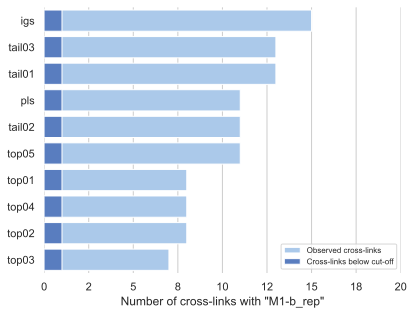

In [10]:
def on_button_click(button):

    counter = count(1, 1)

    file_name = f'{receiver}_cross-links.svg'

    if Path(file_name).is_file():

        file_name_base = file_name.split(".")[0]

        while Path(file_name).is_file():

            file_name = f'{file_name_base}_{next(counter):0>2}.svg'

    message.value = f'<b> Saved to:</b> {file_name}'
    
    f.set_figwidth(3.50394)
    
    f.set_figheight(3)

    f.savefig(file_name, bbox_inches='tight')

button = widgets.Button(description="💾", layout=Layout(width='5%'))

message = widgets.HTML()

display(widgets.HBox([button, message]))

# Plot the count data.
f, ax = plt.subplots()

sns.set_color_codes("pastel")

sns.barplot(x='observed_xls', y='ligand', data=counts_df,
            label='Observed cross-links', color='b')

sns.set_color_codes("muted")

sns.barplot(x='xls_below_cut-off', y='ligand', data=counts_df,
            label='Cross-links below cut-off', color='b')

rounded_max = ceil(counts_df.iloc[:, 1].values.max()/10)*10

ax.legend(ncol=1, loc='lower right', frameon=True, fontsize=8)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set(xlim=(0, rounded_max),
       ylabel='', xlabel=f'Number of cross-links with "{receiver}"')

sns.despine(left=True, bottom=True)

# Add on-click function.
button.on_click(on_button_click)

The above plot displays the number of cross-links observed in the mass spectrometry data and those that are above the set minimum number of observations (considered as top candidates). It can be saved to disk by pressing the floppy disk symbol 💾 above the plot.

### **( ! )** Subset selection: ligand

Select antibody Fab (ligand) of interest in the below dropdown. To rerun the analysis with a different Fab select a new item in the dropdown, and rerun the cells below the input box.

In [11]:
# Display dropdown to enable data subset selection.
top_ligand = counts_df.loc[counts_df['observed_xls'].idxmax()]['ligand']
ligand_subset = widgets.Dropdown(options=ligands,
                               value=top_ligand,
                               description='Ligand:',
                               disabled=False)
display(ligand_subset)

Dropdown(description='Ligand:', options=('igs', 'top03', 'pls', 'tail03', 'top01', 'tail02', 'tail01', 'top04'…

### Structural analysis

... of the selected ligand (antibody).

In [12]:
ligand = ligand_subset.value

tmp_pdb = base_dir / ligand / 'best_model.pdb'

parser = PDBParser()

tmp_structure = parser.get_structure(f'{receiver}--{ligand}', tmp_pdb)

tmp_model = tmp_structure[0]

polypeptides = []

for record in SeqIO.parse(base_dir / ligand / 'input.fasta', 'fasta'):

    polypeptides.append(str(record.seq))

sequence = ''

for chain in tmp_model:

    seq = []

    for res in chain:

        seq.append(aa_3to1[res.resname])

    sequence += ''.join(seq)

search_sequence = str(sequence)

sequence_combined = str(sequence)

pp_indexes = []

for pp in polypeptides:

    while search_sequence.find(pp) > -1:

        idx_start = search_sequence.find(pp)

        idx_full = [idx_start + 1, idx_start + len(pp)]

        search_sequence = search_sequence.replace(pp, '-' * len(pp), 1)

        pp_indexes.append((idx_full, pp))

pp_indexes.sort()

In [13]:
# Generate sequence markdown table.
label = '<br />**Table 1.** Sequence indices.'

headers = '| Start | Stop | Sequence |'

justification = '| :-: | :-: | :- |'

cells = '\n'.join([f'| {pp[0][0]} | {pp[0][1]} | {pp[1]} |' for pp in pp_indexes])

md_table = !echo -e '{headers}\n{justification}\n{cells}'

display(Markdown(label), Markdown('\n'.join(md_table)))

<br />**Table 1.** Sequence indices.

| Start | Stop | Sequence |
| :-: | :-: | :- |
| 1 | 65 | ATALEKELEEKKEALELAIDQASRDYHRATALEKELEEKKKALELAIDQASQDYNRANVLEKELE |
| 66 | 130 | ATALEKELEEKKEALELAIDQASRDYHRATALEKELEEKKKALELAIDQASQDYNRANVLEKELE |
| 131 | 337 | QIVLTQSPAIMSASLGERVTMTCTASSSVSSSYLLWYQQKPGSSPKLWIYSTSNLASGVPTRFSGSGSGTSYSLTISSMEAEDAATYYCHQCHRSPLTFGAGTKLELKPKSSPSVTLFPPSSEELETNKATLVCTITDFYPGVVTVDWKVDGTPVTQGMETTQPSKQSNNKYMASSYLTLTARAWERHSSYSCQVTHEGHTVEKSLS |
| 338 | 553 | QIQLVQSGPELKKPGETVKISCKTSGYTFTTTGMQWVQKMPGKGFKWIGWINTHSGETRYAEDFKGRFAFFLETSASTAYLQISNLKNEDTATYFCARWRNYVFDYWGQGTTLTVSSAKTTPPSVYPLAPGSAAQTNSMVTLGCLVKGYFPEPVTVTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTVPSSTWPSETVTCNVAHPASSTKVDKKIVP |

In [14]:
structure = parser.get_structure(ligand, tmp_pdb)

cutoff = 30

top_xls_idx = locate_xls(structure, sequence_combined, top_xls, cutoff)

ms2_xls_idx = locate_xls(structure, sequence_combined, ms2_xls, cutoff)

In [15]:
pdb = base_dir / ligand / 'best_model_corr.pdb'

abc = 'ABCDEFG'

assigned_chains = []

pdb_edit = base_dir / ligand / 'edit.pdb'

pdb_edit.touch()

for i, index in enumerate(pp_indexes):

    idx = f'-{index[0][0]}:{index[0][1]}'

    chain = f'-{abc[i]}'

    assigned_chains.append(abc[i])

    !pdb_selres {idx} {tmp_pdb} | pdb_chain {chain} >> {pdb_edit}

!pdb_tidy {pdb_edit} | pdb_reatom > {pdb}

pdb_edit.unlink()

In [16]:
view_structure = parser.get_structure(ligand, pdb)

representations = ["Backbone", "Cartoon"]

XLs = ['Show', 'Hide']

colors = {'A': '#595959', 'B': '#595969', 'C': '#360568', 'D': '#b79ced'}

view = nv.show_biopython(view_structure[0], default_representation=False)

view.background = 'lightgray'

def change_representation(view, Representation, XLs):

    view.clear()

    for chain in assigned_chains:

        view.add_representation(Representation,
                                selection=f':{chain}', color=colors[chain])

    if XLs in 'Show':

        for xl in ms2_xls_idx:

            view.add_distance(atom_pair=[xl], color='#323031',
                              label_color='black', label_size=5)

        for xl in top_xls_idx:

            view.add_distance(atom_pair=[xl],
                              color='#f26419',
                              label_color='black', label_size=5)

view.center()

view._remote_call("setSize", target="Widget", args=["970px", "970px"])

interact(change_representation,
         view=fixed(view),
         Representation=representations, XLs=XLs)

view

Button(description='Save current coordinates', layout=Layout(width='20%'), style=ButtonStyle())

interactive(children=(Dropdown(description='Representation', options=('Backbone', 'Cartoon'), value='Backbone'…

NGLWidget(background='lightgray')

In [59]:
protein_1 = cellscape.Structure(str(pdb))

protein_2 = cellscape.Structure(str(pdb))

protein_2.view = view

cartoon_1 = protein_1.outline("chain", depth="contours", depth_contour_interval=5)

cartoon_2 = protein_2.outline("chain", depth="contours", depth_contour_interval=5)

cartoon_colors = [c for c in colors.values()]

fig, axes = plt.subplots(1, 2)

plt.close('all')

cartoon_1.plot(colors=cartoon_colors, depth_shading=True, depth_lines=True, axes_labels=False, axes=axes[0])
cartoon_2.plot(colors=cartoon_colors, depth_shading=True, depth_lines=True, axes_labels=False, axes=axes[1])

fig

Outlined 34 polygons!
Outlined 26 polygons!


The above representation shows the **antibody Fab (purple)** docked to the **antigen (gray)**. Cross-links can be toggled to show where those within the given cutoff (30 Ångström) could theoretically be observed (black), and where they were observed in the mass spectrometry data (orange). Floating numbers are euclidean distances, in Ångström, between the alpha-carbons of the cross-linked lysines.

In [18]:
# TODO:
# - Add button to save the current state (coordinates) of the above structure
#   - Could be used with other packages to generate stylized figures
#   - Save coordinates to disk

Below are code cells with unused but useful code.

In [19]:
# ligand_ms2_xls = df.loc[(receiver, ligand), 'XL']

# ligand_model_xls = df.loc[(receiver, ligand),
#                           :].query(f'XL in {top_xls}').loc[:, 'XL']